In [1]:
import torch
# torch.set_num_threads(2)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from refiners.fluxion.utils import manual_seed, no_grad
from anydoor_refiners.preprocessing import preprocess_images
from anydoor_refiners.model import AnyDoor, AnydoorAutoencoder
from anydoor_refiners.dinov2 import DINOv2Encoder
from anydoor_refiners.unet import UNet
from anydoor_refiners.controlnet import ControlNet


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16

In [ ]:
lda = AnydoorAutoencoder(device=device, dtype=dtype)
encoder = DINOv2Encoder(device=device,dtype=dtype)
unet = UNet(4,device=device,dtype=dtype)
controlnet = ControlNet(4,device=device,dtype=dtype)
anydoor = AnyDoor(
    unet=unet,
    lda=lda,
    control_model=controlnet,
    object_encoder=encoder,
    device=device,
    dtype=dtype,
)

In [ ]:
anydoor.unet.load_from_safetensors("ckpt/anydoor_refiners_safetensors/unet.safetensors")
anydoor.control_model.load_from_safetensors("ckpt/anydoor_refiners_safetensors/controlnet.safetensors")
anydoor.object_encoder.load_from_safetensors("ckpt/anydoor_refiners_safetensors/dinov2_encoder.safetensors")
anydoor.lda.load_from_safetensors("ckpt/anydoor_refiners_safetensors/lda.safetensors")
True # to avoid printing the model summary

In [5]:
# hyperparameters
seed = 42
uncod_scale = 5.0
num_inference_steps = 50
anydoor.set_inference_steps(num_inference_steps, first_step=0)

In [10]:
background_image_path = 'examples/background.png'
background_mask_path = 'examples/background_mask.png'
object_image_path = 'examples/object.png'

object_image = cv2.imread(object_image_path, cv2.IMREAD_UNCHANGED)
object_mask = (object_image[:,:,-1] > 128).astype(np.uint8)
object_image = object_image[:,:,:-1]
object_image = cv2.cvtColor(object_image.copy(), cv2.COLOR_BGR2RGB)
ref_image = object_image 
ref_mask = object_mask

# background image
back_image = cv2.imread(background_image_path).astype(np.uint8)
back_image = cv2.cvtColor(back_image, cv2.COLOR_BGR2RGB)

# background mask 
tar_mask = cv2.imread(background_mask_path)[:,:,0] > 128
tar_mask = tar_mask.astype(np.uint8)

preprocessed_images = preprocess_images(ref_image, ref_mask, back_image.copy(), tar_mask)

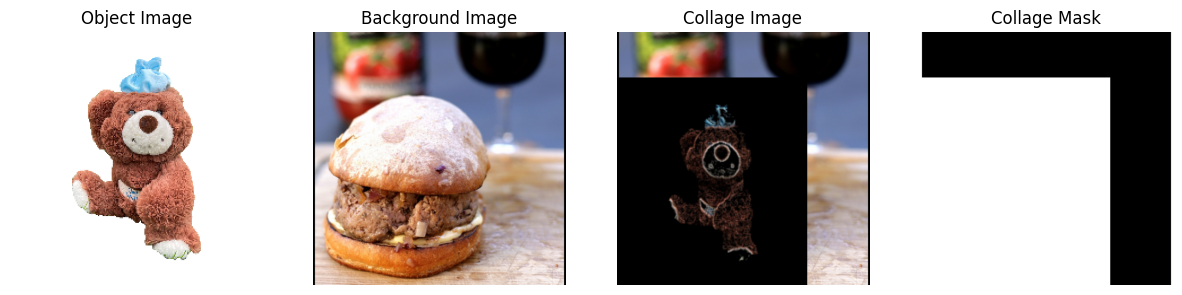

In [16]:
def display_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (title, img) in enumerate(images.items()):
        # Rescale image if it's in the range [-1, 1] to [0, 1]
        if np.min(img) < 0 or np.max(img) > 1:
            img = (img + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(title)
    plt.show()

display_images({
    "Object Image": preprocessed_images["object"] ,
    "Background Image": preprocessed_images["background"] ,
    "Collage Image": preprocessed_images["collage"][:,:,:-1] ,
    "Collage Mask": np.stack([preprocessed_images["collage"][:,:,-1]] * 3, axis=-1) ,
})

In [13]:
control_tensor = torch.from_numpy(preprocessed_images['collage'] .copy()).to(device = device, dtype = dtype).unsqueeze(0).permute(0,3,1,2)
object_tensor = torch.from_numpy(preprocessed_images['object'].copy()).to(device = device, dtype = dtype).unsqueeze(0).permute(0,3,1,2)

In [ ]:
with no_grad():  
    manual_seed(seed)
    object_embedding = anydoor.object_encoder(object_tensor)
    negative_object_embedding = anydoor.object_encoder(torch.zeros((object_image.shape[0], 3, 224, 224),device=device,dtype=dtype))
    x = anydoor.init_latents((256, 256))

    # diffusion denoising process
    for step in tqdm(anydoor.steps):
        x = anydoor.forward(
            x,
            step=step,
            control_background_image= control_tensor,
            object_embedding= object_embedding,
            negative_object_embedding= negative_object_embedding,
            condition_scale= 5.0
        )
    predicted_image = anydoor.lda.latents_to_image(x)



  0%|          | 0/50 [02:18<?, ?it/s]


KeyboardInterrupt: 

In [28]:
for i,t in enumerate(control_dino):
    print(t.shape, control[i].shape)

torch.Size([1, 320, 32, 32]) torch.Size([1, 320, 32, 32])
torch.Size([1, 320, 32, 32]) torch.Size([1, 320, 32, 32])
torch.Size([1, 320, 32, 32]) torch.Size([1, 320, 32, 32])
torch.Size([1, 320, 16, 16]) torch.Size([1, 320, 16, 16])
torch.Size([1, 640, 16, 16]) torch.Size([1, 640, 16, 16])
torch.Size([1, 640, 16, 16]) torch.Size([1, 640, 16, 16])
torch.Size([1, 640, 8, 8]) torch.Size([1, 640, 8, 8])
torch.Size([1, 1280, 8, 8]) torch.Size([1, 1280, 8, 8])
torch.Size([1, 1280, 8, 8]) torch.Size([1, 1280, 8, 8])
torch.Size([1, 1280, 4, 4]) torch.Size([1, 1280, 4, 4])
torch.Size([1, 1280, 4, 4]) torch.Size([1, 1280, 4, 4])
torch.Size([1, 1280, 4, 4]) torch.Size([1, 1280, 4, 4])
torch.Size([1, 1280, 4, 4]) torch.Size([1, 1280, 4, 4])


In [7]:
with torch.no_grad():       
    x = torch.randn(1, 4, 32, 32, dtype=torch.float16, device="cuda")
    timestep = torch.full((1,), 1, dtype=torch.long, device="cuda")
    object_embedding = torch.randn(1, 1, 1024, dtype=torch.float16, device="cuda")
    control = torch.load("tests/tensors/control_features.pt",weights_only=True)
    control = [t.to("cuda").to(torch.float16) for t in control]
    anydoor.unet.set_timestep(timestep)
    anydoor.unet.set_dinov2_object_embedding(object_embedding)
    anydoor.unet.set_control_residuals(control)
    y = anydoor.unet(x)

In [11]:
with torch.no_grad():
    timestep = anydoor.solver.timesteps[1].unsqueeze(dim=0)

    anydoor.set_unet_context(
            timestep=timestep,
            object_embedding=object_embedding,
            control_features=control,
        )
    anydoor.unet(x)

In [15]:
len(control)

13

In [16]:
timestep

tensor([961], device='cuda:0')